In [1]:
from collections import namedtuple
from functools import partial
import os
import pickle
import sys
import warnings

import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision

from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, EpochScoring, LRScheduler
from skorch.dataset import CVSplit
from skorch.exceptions import SkorchWarning

from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore', category=SkorchWarning)

sys.path.append('..')

from dropout.nn import PenalizedNet, GaussianDropoutNet, EtaTrickNet, AdaptiveScaledBernoulliDropoutNet, AdaptiveTikhonovNet, AdaptiveProxNet, PenalizedCriterion, LogSumPenalty, LogSumDualPenalty
from dropout.extern import VarDropNet, SGVLB

In [2]:
# to prevent `too many files` problem
torch.multiprocessing.set_sharing_strategy('file_system')


mnist_train = torchvision.datasets.MNIST('~/data/', 
    train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

mnist_test = torchvision.datasets.MNIST('~/data/', 
    train=False, download=True,
        transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))


y_train = np.asarray([y for x, y in iter(mnist_train)])
y_test = np.asarray([y for x, y in iter(mnist_test)])

cv_split = CVSplit(0.2, random_state=42)

In [3]:
class AdaptiveCallback(Callback):
    
    def __init__(self, lr_scale=1.0):
        
        super(AdaptiveCallback, self).__init__()
        self.lr_scale = lr_scale
    
    def on_batch_end(self, net, *args, **kwargs):
        
        if net.module is VarDropNet:
            return
        
        if net.module is AdaptiveProxNet:
            net.module_.lr = net.optimizer_.param_groups[0]['lr'] * self.lr_scale
            
            if net.optimizer is torch.optim.Adam:
                net.module_.update_alphas_Adam(net.optimizer_)
            else:
                net.module_.update_alphas()
            net.module_.prox()
        else:
            net.module_.update_alphas()

class PenalizedNetCallback(Callback):
    
    def on_train_begin(self, net, *args, **kwargs):
        
        net.criterion_.set_penalty_from_net(net.module_)
        
class LamdaScheduler(Callback):
    
    def __init__(self, lamda_lambda):
        
        super(LamdaScheduler, self).__init__()
        
        self.lamda_lambda = lamda_lambda
        self.lamda0 = None
    
    def on_train_begin(self, net, *args, **kwargs):
        
        self.lamda0 = net.module_.lamda
    
    def on_epoch_begin(self, net, *args, **kwargs):
        
        epoch = len(net.history)
        net.module_.lamda = self.lamda0 * self.lamda_lambda(epoch)

class SGVLBCallback(Callback):
    
    def __init__(self, train_size):
        
        super(SGVLBCallback, self).__init__()
        
        self.train_size = train_size
    
    def on_train_begin(self, net, *args, **kwargs):
        
        net.criterion_.set_params(net.module_, self.train_size)

def sparsity_scoring(net, X, y):
    
    sparsities = net.module_.sparsity()
    ns_zeros, sizes = zip(*sparsities)
    
    return sum(ns_zeros) / sum(sizes)

def min_alpha_scoring(net, X, y):
    
    if net.module is VarDropNet:
        min_eta = torch.exp(-torch.max(net.module_.fc1.log_alpha)).item()
        return min_eta / (min_eta + 1)
    else:
        return torch.min(net.module_.linears[0].alpha).item()

def mean_alpha_scoring(net, X, y):
    return torch.mean(net.module_.linears[0].alpha).item()

In [4]:
def eta_hat(w):
    w = torch.abs(w)
    return w * (w + 2)

class LinearDecay(object):
    
    def __init__(self, to=0):
        
        self.to = to
    
    def __call__(self, epoch):
        
        return self.to + (1 - epoch / epochs) * (1 - self.to)

NetSettings = namedtuple('NetSettings', [
    'name', 
    'module', 
    'criterion', 
    'optimizer', 
    'callbacks', 
    'lamda',
    'lr',
    'kwargs'
])

In [5]:
dims = [784, 300, 100, 10]
tol = 0.05
epochs = 200

nets_settings = [
    NetSettings(name='VariationalDropout', #OK
                module=VarDropNet,
                criterion=SGVLB,
                optimizer=torch.optim.Adam,
                callbacks=[
                    SGVLBCallback(len(y_train)),
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay())
                ],
                lamda=None,
                lr=1e-4,
                kwargs=dict(
                    module__reparam='additive',
                    module__threshold=np.log((1 - tol) / tol)
                )
               ),
    NetSettings(name='VariationalDropoutNoAR', #OK
                module=VarDropNet,
                criterion=SGVLB,
                optimizer=torch.optim.Adam,
                callbacks=[
                    SGVLBCallback(len(y_train)),
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay()),
                    EpochScoring(min_alpha_scoring, name='min_alpha', on_train=True)
                ],
                lamda=None,
                lr=1e-3,
                kwargs=dict(
                    module__reparam='local',
                    module__threshold=np.log((1 - tol) / tol)
                )
               ),
    NetSettings(name='VariationalDropoutNoReparam', #OK
                module=VarDropNet,
                criterion=SGVLB,
                optimizer=torch.optim.Adam,
                callbacks=[
                    SGVLBCallback(len(y_train)),
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay()),
                    EpochScoring(min_alpha_scoring, name='min_alpha', on_train=True)
                ],
                lamda=None,
                lr=1e-3,
                kwargs=dict(
                    module__reparam=None,
                    module__threshold=np.log((1 - tol) / tol)
                )
               ),
    NetSettings(name='LogSum', #OK
                module=PenalizedNet,
                criterion=PenalizedCriterion,
                optimizer=torch.optim.Adam,
                callbacks=[
                    PenalizedNetCallback(),
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay())
                ],
                lamda=1e-3,
                lr=1e-4,
                kwargs=dict(
                    module__penalty_module=LogSumPenalty,
                    module__penalty_params=dict(epsilon=2),
                    criterion__criterion_class=torch.nn.CrossEntropyLoss
                )
               ),
#    NetSettings(name='GaussianDropout', #OK
#                module=GaussianDropoutNet,
#                criterion=PenalizedCriterion,
#                optimizer=torch.optim.Adam,
#                callbacks=[
#                    PenalizedNetCallback(),
#                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay()),
#                    EpochScoring(min_alpha_scoring, name='min_alpha', on_train=True)
#                ],
#                lamda=1 / len(y_train),
#                lr=1e-3,
#                kwargs=dict(
#                    module__dual_penalty_module=LogSumDualPenalty,
#                    module__dual_penalty_params=dict(epsilon=2),
#                    module__eta_hat_init=None,
#                    criterion__criterion_class=torch.nn.CrossEntropyLoss
#                )
#               ),
    NetSettings(name='EtaTrick', #OK
                module=EtaTrickNet,
                criterion=PenalizedCriterion,
                optimizer=torch.optim.Adam,
                callbacks=[
                    PenalizedNetCallback(),
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay()),
                    EpochScoring(min_alpha_scoring, name='min_alpha', on_train=True)
                ],
                lamda=1e-3,
                lr=1e-3,
                kwargs=dict(
                    module__dual_penalty_module=LogSumDualPenalty,
                    module__dual_penalty_params=dict(epsilon=2),
                    module__eta_hat_init=None,
                    module__eta_weight_decay=1e-3,
                    criterion__criterion_class=torch.nn.CrossEntropyLoss
                )
               ),
#    NetSettings(name='ScaledBernoulliDropout', #OK
#                module=AdaptiveScaledBernoulliDropoutNet,
#                criterion=torch.nn.CrossEntropyLoss,
#                optimizer=torch.optim.Adam,
#                callbacks=[
#                    EpochScoring(mean_alpha_scoring, name='mean_alpha', on_train=True),
#                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay()),
#                    LamdaScheduler(LinearDecay(1e3))
#                ],
#                lamda=1e-3,
#                lr=1e-4,
#                kwargs=dict(
#                    module__eta_hat=eta_hat
#                )
#               ),
    NetSettings(name='ProxSGD', #OK
                module=AdaptiveProxNet,
                criterion=torch.nn.CrossEntropyLoss,
                optimizer=torch.optim.Adam,
                callbacks=[
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay())
                ],
                lamda=1e-3,
                lr=1e-4,
                kwargs=dict(
                    module__eta_hat=eta_hat,
                )
               ),
    NetSettings(name='Tikhonov', #OK
                module=AdaptiveTikhonovNet,
                criterion=PenalizedCriterion,
                optimizer=torch.optim.Adam,
                callbacks=[
                    PenalizedNetCallback(),
                    LRScheduler(policy=torch.optim.lr_scheduler.LambdaLR, lr_lambda=LinearDecay())
                ],
                lamda=1e-3,
                lr=1e-4,
                kwargs=dict(
                    module__eta_hat=eta_hat,
                    criterion__criterion_class=torch.nn.CrossEntropyLoss
                )
               )
]

In [6]:
def train_net(net_settings):
    
    net = NeuralNetClassifier(
        net_settings.module,
        criterion=net_settings.criterion,
        predict_nonlinearity=partial(torch.softmax, dim=-1),
        optimizer=net_settings.optimizer,
        callbacks=[
            AdaptiveCallback(),
            EpochScoring(sparsity_scoring, name='sparsity', on_train=True, lower_is_better=False)
        ] + net_settings.callbacks,
        module__dims=dims,
        module__lamda=net_settings.lamda,
        module__tol=tol,
        lr=net_settings.lr,
        batch_size=128,
        train_split=cv_split,
        max_epochs=epochs,
        iterator_train__num_workers=4,
        iterator_valid__num_workers=4,
        device='cuda',
        **net_settings.kwargs,
    )
    
    print('*' * 40)
    print('Training with %s' % net_settings.name)
    print('*' * 40)
    
    net.fit(mnist_train, y=y_train)
    
    print('')
    
    return net

In [7]:
nets = []

os.makedirs('nets', exist_ok=True)

for ns in nets_settings:
    
    net = train_net(ns)
    net.settings = ns
    
    with open(os.path.join('nets', '%s.pkl' % ns.name), 'wb') as f:
        pickle.dump(net, f)
        
    nets.append(net)

****************************************
Training with VariationalDropout
****************************************
  epoch    sparsity    train_loss    valid_acc    valid_loss      lr     dur
-------  ----------  ------------  -----------  ------------  ------  ------
      1      0.8096    35198.8492       0.7990   -82630.8340  0.0001  2.7406
      2      0.8848   -97320.3237       0.8493  -105146.0666  0.0001  2.2396
      3      0.9098  -109545.0676       0.8682  -112748.6836  0.0001  2.2037
      4      0.9220  -115168.1600       0.8775  -117336.7185  0.0001  2.2542
      5      0.9305  -118974.7802       0.8848  -120735.2929  0.0001  2.2369
      6      0.9352  -121995.9478       0.8904  -123470.5462  0.0001  2.2601
      7      0.9401  -124463.1998       0.8950  -125762.4497  0.0001  2.2363
      8      0.9432  -126622.8917       0.8992  -127791.0915  0.0001  2.2392
      9      0.9468  -128509.7241       0.9041  -129591.5220  0.0001  2.1846
     10      0.9483  -130193.5151     

     73      0.9709  -153644.1869       0.9531  -153193.5900  0.0001  2.2401
     74      0.9710  -153705.5125       0.9531  -153262.5793  0.0001  2.2261
     75      0.9712  -153757.8682       0.9534  -153334.9401  0.0001  2.2531
     76      0.9713  -153800.9370       0.9539  -153415.5480  0.0001  2.2278
     77      0.9710  -153841.2762       0.9536  -153480.5215  0.0001  2.2590
     78      0.9713  -153982.2750       0.9545  -153552.3194  0.0001  2.2195
     79      0.9711  -154023.0113       0.9546  -153611.8996  0.0001  2.2162
     80      0.9715  -154153.9367       0.9544  -153687.2205  0.0001  2.2379
     81      0.9713  -154130.4142       0.9548  -153741.2626  0.0001  2.2645
     82      0.9715  -154269.3017       0.9548  -153832.6087  0.0001  2.3093
     83      0.9717  -154297.0904       0.9549  -153886.2153  0.0001  2.2649
     84      0.9719  -154385.5974       0.9554  -153952.0692  0.0001  2.2933
     85      0.9721  -154459.7732       0.9554  -154016.2898  0.0001  2.2105

    155      0.9755  -156643.7401       0.9617  -156151.2117  0.0000  2.2278
    156      0.9755  -156667.8703       0.9619  -156163.2391  0.0000  2.2396
    157      0.9754  -156664.7528       0.9618  -156188.0553  0.0000  2.4230
    158      0.9755  -156718.5259       0.9618  -156191.1485  0.0000  2.2924
    159      0.9756  -156591.1238       0.9619  -156209.2236  0.0000  2.2062
    160      0.9756  -156696.9317       0.9620  -156215.1572  0.0000  2.2688
    161      0.9756  -156748.0201       0.9617  -156226.2820  0.0000  2.2548
    162      0.9755  -156718.1310       0.9620  -156236.8348  0.0000  2.2806
    163      0.9756  -156744.6937       0.9615  -156240.5372  0.0000  2.2519
    164      0.9756  -156785.9269       0.9621  -156262.1299  0.0000  2.2222
    165      0.9756  -156698.2268       0.9622  -156268.5098  0.0000  2.2372
    166      0.9757  -156832.7762       0.9619  -156275.4651  0.0000  2.2753
    167      0.9757  -156737.1933       0.9623  -156296.3688  0.0000  2.2115

     31       0.0440      0.4089  -144905.7230       0.9804  -145528.5046  0.0008  2.1983
     32       0.0381      0.4753  -145627.5273       0.9800  -146562.3565  0.0008  2.2629
     33       0.0333      0.5121  -146702.2562       0.9782  -146730.9438  0.0008  2.1951
     34       0.0287      0.5390  -147316.9386       0.9796  -147711.4688  0.0008  2.2397
     35       0.0249      0.5610  -147923.4080       0.9768  -147724.3789  0.0008  2.1858
     36       0.0217      0.5795  -148455.1775       0.9801  -149082.9873  0.0008  2.2083
     37       0.0188      0.5964  -149025.5946       0.9779  -149194.1962  0.0008  2.2460
     38       0.0163      0.6110  -149500.2798       0.9783  -149914.8093  0.0008  2.2091
     39       0.0142      0.6246  -150006.4981       0.9774  -150032.3551  0.0008  2.1922
     40       0.0124      0.6369  -150410.8483       0.9780  -150743.0593  0.0008  2.1999
     41       0.0108      0.6480  -150845.7705       0.9778  -150901.1610  0.0008  2.2201
     42   

     99       0.0007      0.8645  -157459.3218       0.9818  -158098.0913  0.0005  2.1918
    100       0.0007      0.8659  -157317.1660       0.9818  -158050.2189  0.0005  2.2389
    101       0.0007      0.8671  -157511.3534       0.9825  -158219.7926  0.0005  2.1884
    102       0.0007      0.8683  -157573.4550       0.9818  -158203.5232  0.0005  2.1743
    103       0.0007      0.8696  -157625.6830       0.9818  -158288.0900  0.0005  2.2645
    104       0.0007      0.8707  -157693.2832       0.9824  -158270.7460  0.0005  2.2661
    105       0.0007      0.8717  -157571.6214       0.9817  -158263.8008  0.0005  2.1954
    106       0.0007      0.8727  -157765.7400       0.9818  -158354.6247  0.0005  2.2281
    107       0.0007      0.8738  -157847.1144       0.9819  -158410.7653  0.0005  2.2415
    108       0.0007      0.8749  -157768.5468       0.9818  -158506.7665  0.0005  2.1953
    109       0.0007      0.8759  -158006.5175       0.9825  -158497.0676  0.0005  2.1981
    110   

    170       0.0004      0.9081  -159701.0896       0.9828  -159737.1730  0.0002  2.2051
    171       0.0004      0.9083  -159929.1923       0.9822  -159758.9170  0.0002  2.1767
    172       0.0004      0.9085  -159736.0082       0.9832  -159762.3686  0.0001  2.2084
    173       0.0004      0.9086  -159717.9323       0.9827  -159752.9323  0.0001  2.2135
    174       0.0004      0.9088  -159681.1790       0.9828  -159798.8045  0.0001  2.2195
    175       0.0004      0.9090  -159888.7431       0.9828  -159801.4368  0.0001  2.2146
    176       0.0004      0.9092  -159960.5721       0.9831  -159832.1754  0.0001  2.1939
    177       0.0004      0.9094  -160045.7125       0.9827  -159838.4651  0.0001  2.1860
    178       0.0004      0.9096  -159931.9192       0.9828  -159840.8888  0.0001  2.2328
    179       0.0004      0.9097  -160000.3380       0.9826  -159816.1986  0.0001  2.2234
    180       0.0003      0.9099  -159962.4590       0.9829  -159857.0738  0.0001  2.1646
    181   

     37       0.0237      0.0052  -117805.0245       0.9811  -116640.4450  0.0008  1.9391
     38       0.0233      0.0066  -118980.7307       0.9815  -117686.8429  0.0008  1.9901
     39       0.0224      0.0081  -119418.1237       0.9806  -118720.2311  0.0008  1.9477
     40       0.0212      0.0096  -120523.9637       0.9806  -119436.2863  0.0008  1.9391
     41       0.0210      0.0114  -121488.3628       0.9816  -120581.0565  0.0008  1.9518
     42       0.0209      0.0132  -122290.1458       0.9822  -121357.7034  0.0008  1.8815
     43       0.0210      0.0154  -122999.2643       0.9823  -122068.6276  0.0008  1.8802
     44       0.0209      0.0176  -123905.5174       0.9814  -122782.8441  0.0008  1.9636
     45       0.0208      0.0199  -124255.1374       0.9818  -123522.7053  0.0008  1.9942
     46       0.0210      0.0220  -125034.0330       0.9811  -124186.7607  0.0008  1.9633
     47       0.0205      0.0243  -125587.7119       0.9810  -124796.4670  0.0008  1.9504
     48   

    104       0.0107      0.2177  -142413.7672       0.9832  -142527.4613  0.0005  1.9671
    105       0.0103      0.2212  -142725.5974       0.9836  -142694.4090  0.0005  1.9090
    106       0.0100      0.2247  -142595.5900       0.9835  -142817.0940  0.0005  1.9794
    107       0.0099      0.2284  -142928.1861       0.9829  -142891.2646  0.0005  1.9147
    108       0.0097      0.2315  -142894.9590       0.9835  -143092.8657  0.0005  1.9599
    109       0.0096      0.2350  -142983.0145       0.9831  -143174.9084  0.0005  1.9769
    110       0.0096      0.2384  -143068.2037       0.9823  -143212.4955  0.0005  1.9545
    111       0.0096      0.2417  -143401.9965       0.9830  -143335.6026  0.0004  1.9576
    112       0.0096      0.2450  -143349.6342       0.9832  -143522.7707  0.0004  1.9324
    113       0.0095      0.2483  -143300.8381       0.9826  -143612.8961  0.0004  1.9301
    114       0.0095      0.2516  -143707.9451       0.9832  -143715.9120  0.0004  1.9582
    115   

    173       0.0075      0.3878  -147776.4580       0.9838  -147686.3497  0.0001  1.9136
    174       0.0075      0.3890  -147854.4422       0.9838  -147737.9725  0.0001  1.9510
    175       0.0075      0.3902  -147877.9388       0.9835  -147748.2820  0.0001  1.9232
    176       0.0075      0.3914  -148092.8034       0.9838  -147791.8727  0.0001  1.9250
    177       0.0074      0.3925  -147955.9539       0.9839  -147778.6897  0.0001  1.9353
    178       0.0074      0.3935  -148016.7542       0.9839  -147837.7115  0.0001  1.8947
    179       0.0074      0.3945  -148005.9113       0.9841  -147883.4402  0.0001  1.9567
    180       0.0073      0.3955  -148042.9351       0.9841  -147910.1267  0.0001  1.9283
    181       0.0073      0.3963  -148001.3641       0.9840  -147971.9454  0.0001  1.9151
    182       0.0073      0.3972  -148126.9758       0.9838  -147962.0341  0.0001  1.9361
    183       0.0073      0.3979  -148182.9080       0.9838  -147994.0292  0.0001  1.9074
    184   

     43      0.8353      184.8428       0.9641      184.8555  0.0001  2.1368
     44      0.8362      184.8413       0.9643      184.8542  0.0001  1.8801
     45      0.8362      184.8399       0.9647      184.8530  0.0001  1.8799
     46      0.8377      184.8385       0.9648      184.8518  0.0001  1.8690
     47      0.8404      184.8372       0.9649      184.8506  0.0001  1.9594
     48      0.8408      184.8359       0.9652      184.8496  0.0001  1.8381
     49      0.8426      184.8347       0.9653      184.8485  0.0001  1.8824
     50      0.8441      184.8335       0.9653      184.8475  0.0001  1.8770
     51      0.8461      184.8323       0.9656      184.8465  0.0001  1.8614
     52      0.8480      184.8312       0.9656      184.8455  0.0001  1.8954
     53      0.8480      184.8301       0.9656      184.8445  0.0001  1.9253
     54      0.8491      184.8290       0.9657      184.8435  0.0001  1.8682
     55      0.8516      184.8279       0.9663      184.8425  0.0001  1.8881

    121      0.8966      184.7890       0.9687      184.8098  0.0000  1.8543
    122      0.8969      184.7887       0.9686      184.8095  0.0000  1.8616
    123      0.8973      184.7884       0.9686      184.8092  0.0000  1.8726
    124      0.8981      184.7881       0.9686      184.8090  0.0000  1.9404
    125      0.8972      184.7877       0.9687      184.8087  0.0000  1.8784
    126      0.8988      184.7874       0.9686      184.8085  0.0000  1.8986
    127      0.8985      184.7871       0.9685      184.8082  0.0000  1.8901
    128      0.8992      184.7868       0.9686      184.8079  0.0000  1.9372
    129      0.8994      184.7865       0.9687      184.8077  0.0000  1.8686
    130      0.9008      184.7862       0.9686      184.8074  0.0000  1.8810
    131      0.9007      184.7859       0.9687      184.8072  0.0000  1.9226
    132      0.9013      184.7856       0.9688      184.8070  0.0000  1.8820
    133      0.9014      184.7853       0.9685      184.8067  0.0000  1.8949


****************************************
Training with EtaTrick
****************************************
  epoch    min_alpha    sparsity    train_loss    valid_acc    valid_loss      lr     dur
-------  -----------  ----------  ------------  -----------  ------------  ------  ------
      1       0.9891      0.0000      185.8619       0.9462      185.6177  0.0010  2.2506
      2       0.9841      0.0000      185.5486       0.9549      185.4938  0.0010  2.1755
      3       0.9776      0.0000      185.4384       0.9568      185.4165  0.0010  2.1901
      4       0.9680      0.0000      185.3577       0.9637      185.3361  0.0010  2.1937
      5       0.9549      0.0000      185.2902       0.9661      185.2768  0.0010  2.1571
      6       0.9372      0.0000      185.2337       0.9688      185.2259  0.0010  2.1717
      7       0.9136      0.0000      185.1834       0.9709      185.1763  0.0010  2.2159
      8       0.8824      0.0000      185.1363       0.9720      185.1308  0.0010  2

     65       0.0004      0.9007      183.8650       0.9755      183.9135  0.0007  2.2301
     66       0.0004      0.9012      183.8614       0.9752      183.9059  0.0007  2.1593
     67       0.0004      0.9016      183.8573       0.9753      183.9007  0.0007  2.2289
     68       0.0004      0.9019      183.8532       0.9746      183.8949  0.0007  2.1357
     69       0.0004      0.9023      183.8512       0.9754      183.8929  0.0007  2.2144
     70       0.0004      0.9035      183.8462       0.9754      183.8874  0.0007  2.2097
     71       0.0004      0.9039      183.8439       0.9751      183.8831  0.0007  2.1679
     72       0.0004      0.9043      183.8396       0.9743      183.8838  0.0006  2.2075
     73       0.0004      0.9046      183.8364       0.9754      183.8781  0.0006  2.1627
     74       0.0003      0.9050      183.8329       0.9751      183.8744  0.0006  2.2477
     75       0.0003      0.9053      183.8293       0.9747      183.8728  0.0006  2.1644
     76   

    131       0.0001      0.9309      183.6385       0.9764      183.7012  0.0003  2.2090
    132       0.0001      0.9312      183.6346       0.9758      183.6997  0.0003  2.2187
    133       0.0001      0.9315      183.6308       0.9759      183.6907  0.0003  2.1777
    134       0.0001      0.9319      183.6266       0.9762      183.6894  0.0003  2.1968
    135       0.0001      0.9323      183.6229       0.9760      183.6887  0.0003  2.1805
    136       0.0001      0.9327      183.6188       0.9760      183.6817  0.0003  2.1959
    137       0.0001      0.9329      183.6150       0.9758      183.6783  0.0003  2.1997
    138       0.0001      0.9333      183.6107       0.9762      183.6749  0.0003  2.1569
    139       0.0001      0.9336      183.6070       0.9761      183.6719  0.0003  2.1717
    140       0.0001      0.9339      183.6028       0.9761      183.6673  0.0003  2.2146
    141       0.0001      0.9343      183.5986       0.9760      183.6648  0.0003  2.3540
    142   

    196       0.0000      0.9485      183.3566       0.9771      183.4220  0.0000  2.2024
    197       0.0000      0.9485      183.3552       0.9771      183.4202  0.0000  2.2210
    198       0.0000      0.9486      183.3542       0.9771      183.4193  0.0000  2.1950
    199       0.0000      0.9487      183.3534       0.9772      183.4187  0.0000  2.2256
    200       0.0000      0.9487      183.3529       0.9771      183.4185  0.0000  2.2025

****************************************
Training with ProxSGD
****************************************
  epoch    sparsity    train_loss    valid_acc    valid_loss      lr     dur
-------  ----------  ------------  -----------  ------------  ------  ------
      1      0.6493        0.8004       0.8922        0.4522  0.0001  1.9278
      2      0.7828        0.4070       0.9029        0.3985  0.0001  1.9067
      3      0.8279        0.3739       0.9081        0.3708  0.0001  1.8912
      4      0.8546        0.3495       0.9138        0.3460

     67      0.9717        0.1147       0.9640        0.1298  0.0001  1.8978
     68      0.9717        0.1143       0.9640        0.1294  0.0001  1.9087
     69      0.9719        0.1139       0.9640        0.1290  0.0001  1.9054
     70      0.9719        0.1134       0.9637        0.1287  0.0001  1.9136
     71      0.9719        0.1130       0.9638        0.1284  0.0001  1.9467
     72      0.9720        0.1126       0.9638        0.1281  0.0001  1.9177
     73      0.9720        0.1123       0.9638        0.1278  0.0001  1.9075
     74      0.9720        0.1119       0.9638        0.1275  0.0001  1.9012
     75      0.9722        0.1115       0.9641        0.1273  0.0001  1.8644
     76      0.9722        0.1112       0.9642        0.1270  0.0001  1.8367
     77      0.9722        0.1108       0.9643        0.1267  0.0001  1.9226
     78      0.9722        0.1105       0.9643        0.1265  0.0001  1.8769
     79      0.9723        0.1101       0.9643        0.1262  0.0001  1.8681

    149      0.9730        0.0975       0.9664        0.1175  0.0000  1.8806
    150      0.9730        0.0974       0.9664        0.1174  0.0000  1.8778
    151      0.9729        0.0973       0.9664        0.1174  0.0000  1.8629
    152      0.9730        0.0972       0.9664        0.1173  0.0000  1.9350
    153      0.9730        0.0971       0.9664        0.1173  0.0000  1.8997
    154      0.9729        0.0970       0.9663        0.1172  0.0000  1.9305
    155      0.9729        0.0970       0.9663        0.1172  0.0000  1.8814
    156      0.9728        0.0969       0.9663        0.1171  0.0000  1.8808
    157      0.9729        0.0968       0.9664        0.1171  0.0000  1.8948
    158      0.9728        0.0967       0.9663        0.1170  0.0000  1.8628
    159      0.9729        0.0966       0.9664        0.1170  0.0000  1.8748
    160      0.9728        0.0966       0.9664        0.1170  0.0000  1.8709
    161      0.9728        0.0965       0.9663        0.1169  0.0000  1.8394

     28      0.7965        0.2412       0.9608        0.2520  0.0001  1.8799
     29      0.8014        0.2383       0.9616        0.2495  0.0001  1.8814
     30      0.8040        0.2357       0.9619        0.2471  0.0001  1.9111
     31      0.8095        0.2332       0.9621        0.2449  0.0001  1.8928
     32      0.8162        0.2309       0.9623        0.2428  0.0001  1.9190
     33      0.8195        0.2287       0.9626        0.2408  0.0001  1.9515
     34      0.8214        0.2266       0.9627        0.2390  0.0001  2.1483
     35      0.8253        0.2247       0.9631        0.2373  0.0001  1.9067
     36      0.8259        0.2229       0.9631        0.2358  0.0001  1.8792
     37      0.8277        0.2213       0.9634        0.2344  0.0001  1.8828
     38      0.8299        0.2197       0.9634        0.2330  0.0001  1.9219
     39      0.8336        0.2181       0.9635        0.2317  0.0001  1.9181
     40      0.8356        0.2167       0.9637        0.2304  0.0001  1.9481

    104      0.8940        0.1769       0.9699        0.1970  0.0000  1.9078
    105      0.8955        0.1766       0.9699        0.1968  0.0000  1.9242
    106      0.8951        0.1763       0.9700        0.1966  0.0000  1.9012
    107      0.8960        0.1760       0.9699        0.1963  0.0000  1.8862
    108      0.8959        0.1757       0.9701        0.1961  0.0000  1.8955
    109      0.8964        0.1755       0.9701        0.1959  0.0000  1.8999
    110      0.8968        0.1752       0.9701        0.1957  0.0000  1.8922
    111      0.8967        0.1749       0.9701        0.1955  0.0000  1.8587
    112      0.8966        0.1747       0.9701        0.1953  0.0000  1.8932
    113      0.8973        0.1744       0.9701        0.1951  0.0000  1.8881
    114      0.8981        0.1742       0.9701        0.1949  0.0000  1.9029
    115      0.8983        0.1739       0.9701        0.1947  0.0000  1.9338
    116      0.8984        0.1737       0.9702        0.1945  0.0000  1.9029

    185      0.9421        0.1639       0.9698        0.1878  0.0000  1.8949
    186      0.9451        0.1638       0.9698        0.1878  0.0000  1.8919
    187      0.9456        0.1638       0.9699        0.1877  0.0000  1.8954
    188      0.9473        0.1637       0.9698        0.1877  0.0000  1.9397
    189      0.9501        0.1637       0.9698        0.1877  0.0000  1.8961
    190      0.9518        0.1636       0.9698        0.1876  0.0000  1.8792
    191      0.9551        0.1636       0.9697        0.1876  0.0000  1.9105
    192      0.9589        0.1635       0.9695        0.1876  0.0000  1.9079
    193      0.9632        0.1635       0.9695        0.1875  0.0000  1.8995
    194      0.9687        0.1634       0.9695        0.1875  0.0000  1.9082
    195      0.9724        0.1634       0.9695        0.1875  0.0000  1.8906
    196      0.9755        0.1633       0.9695        0.1875  0.0000  1.8904
    197      0.9783        0.1633       0.9694        0.1875  0.0000  1.9245

In [8]:
nets = []

for ns in nets_settings:
    
    try:
        with open(os.path.join('nets', '%s.pkl' % ns.name), 'rb') as f:
            net = pickle.load(f)
            
        print(ns.name)

        net.history.record('test_acc', accuracy_score(y_test, net.predict(mnist_test)))
        net.history.to_file(os.path.join('nets', '%s_history.json' % ns.name))
        net.settings = ns

        with open(os.path.join('nets', '%s.pkl' % ns.name), 'wb') as f:
            pickle.dump(net, f)

        nets.append(net)
    
    except Exception as e:
        pass
        

VariationalDropout
VariationalDropoutNoAR
VariationalDropoutNoReparam
LogSum
EtaTrick
ProxSGD
Tikhonov


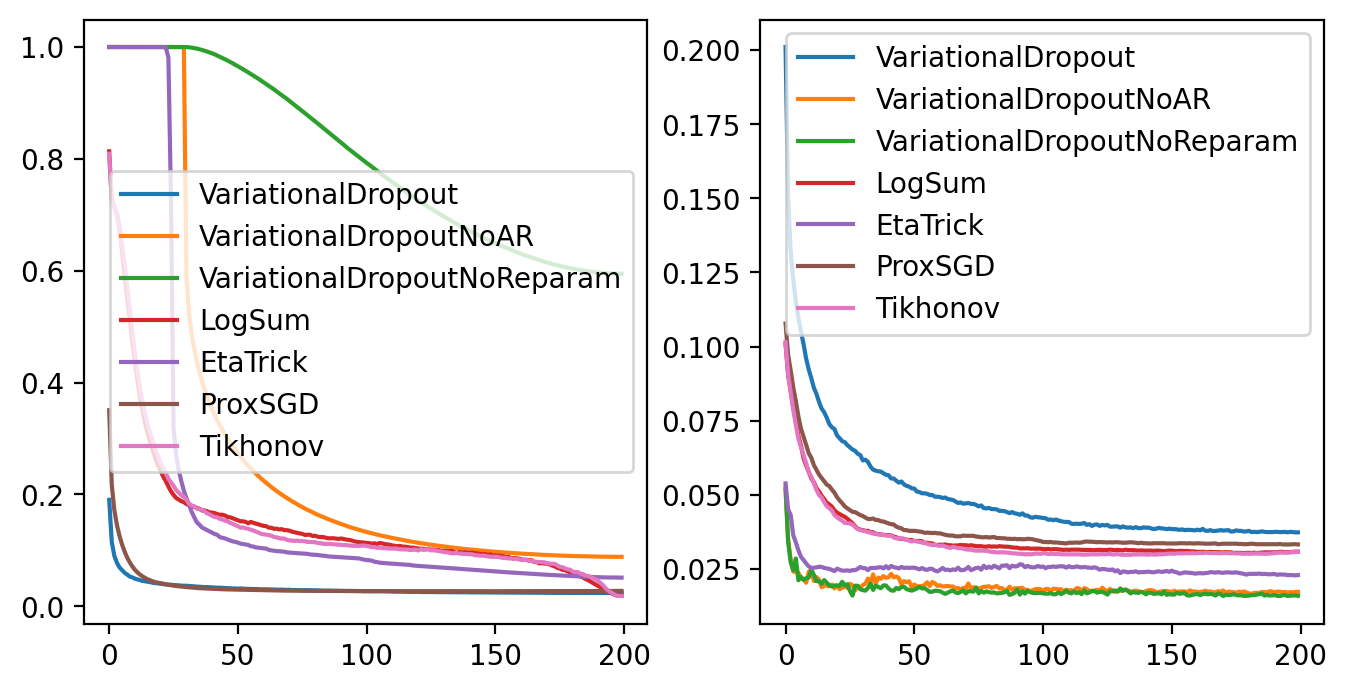

In [9]:
plt.figure(figsize=(8, 4), dpi=200)

plt.subplot(1, 2, 1)

for i, net in enumerate(nets):
    plt.plot((1 - np.asarray(net.history[:, 'sparsity'])), label=net.settings.name)

plt.legend()

plt.subplot(1, 2, 2)

for i, net in enumerate(nets):
    plt.plot(1 - np.asarray(net.history[:, 'valid_acc']), label=net.settings.name)

plt.legend()

plt.show()